Pairwise correlations with fg_score:
fg_score       1.000000
pnl_mean       0.010963
win_rate       0.009548
pnl_sum       -0.032810
trade_count   -0.121448
Name: fg_score, dtype: float64


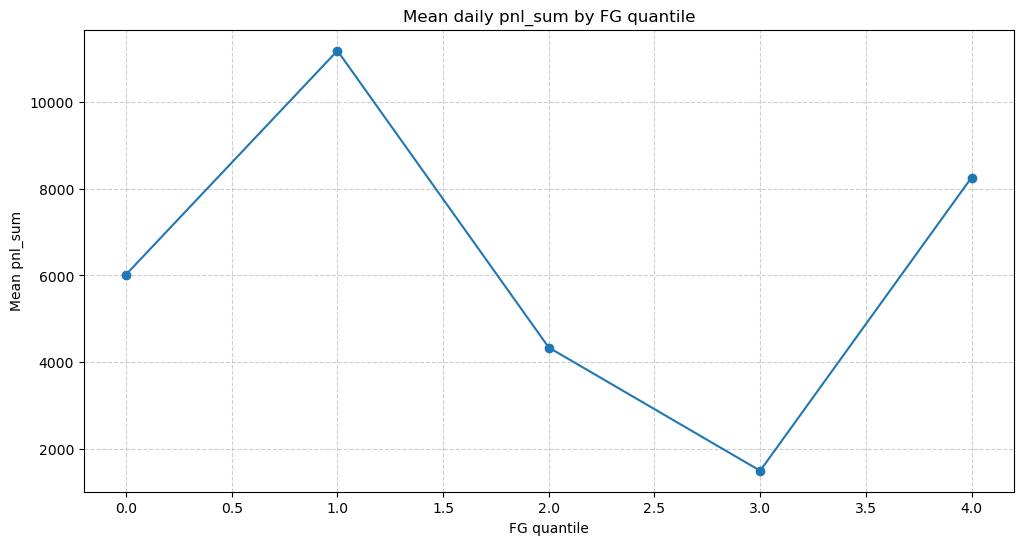

T-test Greed vs Extreme Greed: t=-1.152, p=0.251
Lag corr (fg_score_t-1 vs pnl_sum): -0.03864618324995078
LinearRegression MSE: 952835253.7756466
RandomForestRegressor MSE: 1240672903.3191094
Classifier ROC AUC: 0.530180428984194

Summary table:
        fg_class  days_count  avg_daily_pnl  median_trade_count  avg_win_rate  \
0   Extreme Fear          21    1608.814601                24.0      0.252340   
1  Extreme Greed          56    9143.808658                16.0      0.333832   
2           Fear          63   11386.136221                43.0      0.371901   
3          Greed          86    3383.493680                33.0      0.356266   
4        Neutral          31    1564.399782                24.0      0.290495   

   avg_trade_usd  
0   1.450283e+06  
1   1.608876e+05  
2   8.566327e+05  
3   3.071485e+05  
4   3.061191e+05  

Key insights:
- Linear correlation between FG score and performance metrics is weak.
- Slight negative correlation observed between FG score and trade f

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

plt.rcParams['figure.figsize'] = (12,6)

fear_path = 'fear_greed_index.csv'
hist_path = 'historical_data.csv'

# load sentiment
fg = pd.read_csv(fear_path)
if 'Date' in fg.columns:
    fg['date'] = pd.to_datetime(fg['Date'], errors='coerce')
else:
    date_cols = [c for c in fg.columns if 'date' in c.lower()]
    fg['date'] = pd.to_datetime(fg[date_cols[0]], errors='coerce') if date_cols else pd.to_datetime(fg.iloc[:,0], errors='coerce')
num_candidates = [c for c in fg.columns if any(k in c.lower() for k in ['value','index','score','number'])]
fg['fg_score'] = pd.to_numeric(fg[num_candidates[0]], errors='coerce') if num_candidates else np.nan
class_cols = [c for c in fg.columns if 'class' in c.lower() or 'fear' in c.lower() or 'greed' in c.lower()]
fg['fg_class'] = fg[class_cols[0]].astype(str) if class_cols else np.nan
fg = fg[['date','fg_score','fg_class']].sort_values('date').drop_duplicates('date').reset_index(drop=True)

# load trading history
hist = pd.read_csv(hist_path)

# Build rename map (priority-based) and apply only existing keys
rename_map = {
    'Account': 'account',
    'Coin': 'symbol',
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Side': 'side',
    'Timestamp IST': 'time',
    'Timestamp': 'timestamp_raw',
    'Start Position': 'start_position',
    'Direction': 'direction',
    'Closed PnL': 'closedPnL',
    'Transaction Hash': 'tx_hash',
    'Order ID': 'order_id',
    'Crossed': 'crossed',
    'Fee': 'fee',
    'Trade ID': 'trade_id'
}
existing_renames = {k:v for k,v in rename_map.items() if k in hist.columns}
hist = hist.rename(columns=existing_renames)

# If both a preferred timestamp ('time') and 'timestamp_raw' exist, drop the raw one
if 'time' in hist.columns and 'timestamp_raw' in hist.columns:
    hist = hist.drop(columns=['timestamp_raw'])

# Remove any duplicate column names that still might exist (keep first occurrence)
if hist.columns.duplicated().any():
    hist = hist.loc[:, ~hist.columns.duplicated()]

# Choose timestamp column robustly
if 'time' in hist.columns:
    time_col = 'time'
elif 'timestamp_raw' in hist.columns:
    time_col = 'timestamp_raw'
else:
    time_candidates = [c for c in hist.columns if 'time' in c.lower() or 'timestamp' in c.lower() or 'date' in c.lower()]
    time_col = time_candidates[0] if time_candidates else None

if time_col is None:
    raise ValueError("No timestamp-like column found in historical_data.csv")

hist['time'] = pd.to_datetime(hist[time_col], errors='coerce')
hist = hist[~hist['time'].isna()].copy()
hist['date'] = hist['time'].dt.floor('D')

# numeric conversions
hist['closedPnL'] = pd.to_numeric(hist['closedPnL'], errors='coerce') if 'closedPnL' in hist.columns else np.nan
hist['size_usd'] = pd.to_numeric(hist.get('size_usd', np.nan), errors='coerce')
hist['side'] = hist['side'].astype(str).str.lower() if 'side' in hist.columns else np.nan

# Ensure account exists
if 'account' not in hist.columns:
    hist['account'] = 'unknown'

# Aggregate per account-day
agg_funcs = {
    'closedPnL': ['sum','mean','std','count'],
    'size_usd': ['sum','mean']
}
per_acc_day = hist.groupby(['account','date']).agg(agg_funcs)
per_acc_day.columns = ['_'.join(col).strip() for col in per_acc_day.columns.values]
per_acc_day = per_acc_day.reset_index().rename(columns={
    'closedPnL_sum':'pnl_sum',
    'closedPnL_mean':'pnl_mean',
    'closedPnL_std':'pnl_std',
    'closedPnL_count':'trade_count',
    'size_usd_sum':'trade_usd_sum',
    'size_usd_mean':'trade_usd_mean'
})

if 'trade_count' not in per_acc_day.columns and 'closedPnL_count' in per_acc_day.columns:
    per_acc_day['trade_count'] = per_acc_day['closedPnL_count']

hist['win'] = (hist['closedPnL'] > 0).astype(int)
win_rate = hist.groupby(['account','date'])['win'].mean().reset_index().rename(columns={'win':'win_rate'})
per_acc_day = per_acc_day.merge(win_rate, on=['account','date'], how='left')

# Align dates and trim sentiment to trading range
fg['date'] = fg['date'].dt.floor('D')
hist['date'] = hist['date'].dt.floor('D')
if not hist['date'].isna().all():
    fg = fg[(fg['date'] >= hist['date'].min()) & (fg['date'] <= hist['date'].max())]

merged = per_acc_day.merge(fg, on='date', how='left')
merged['fg_score'] = merged['fg_score'].ffill()
merged['fg_class'] = merged['fg_class'].ffill()

# Correlations
corr_cols = ['pnl_sum','pnl_mean','trade_count','win_rate','fg_score']
corr_existing = [c for c in corr_cols if c in merged.columns]
if corr_existing:
    print('Pairwise correlations with fg_score:')
    print(merged[corr_existing].corr()['fg_score'].sort_values(ascending=False))

# FG quantiles and plot
merged['fg_bin'] = pd.qcut(merged['fg_score'].rank(method='first'), q=5, labels=False, duplicates='drop')
piv = merged.groupby('fg_bin')['pnl_sum'].agg(['mean','median','count']).reset_index()

fig, ax = plt.subplots()
ax.plot(piv['fg_bin'], piv['mean'], marker='o')
ax.set_xlabel('FG quantile')
ax.set_ylabel('Mean pnl_sum')
ax.set_title('Mean daily pnl_sum by FG quantile')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# T-test if classes exist
if merged['fg_class'].notna().any():
    classes = merged['fg_class'].dropna().unique()
    if len(classes) >= 2:
        g1 = merged[merged['fg_class']==classes[0]]['pnl_sum'].dropna()
        g2 = merged[merged['fg_class']==classes[1]]['pnl_sum'].dropna()
        if len(g1)>0 and len(g2)>0:
            t,p = stats.ttest_ind(g1,g2,equal_var=False)
            print(f'T-test {classes[0]} vs {classes[1]}: t={t:.3f}, p={p:.3f}')

# Lagged analysis
merged = merged.sort_values(['account','date'])
merged['fg_score_t_minus_1'] = merged.groupby('account')['fg_score'].shift(1)
tmp = merged.dropna(subset=['fg_score_t_minus_1','pnl_sum'])
if not tmp.empty:
    print('Lag corr (fg_score_t-1 vs pnl_sum):', tmp['fg_score_t_minus_1'].corr(tmp['pnl_sum']))

# Regression models
model_df = merged.dropna(subset=['pnl_sum','fg_score'])[['pnl_sum','fg_score','trade_count','win_rate']].fillna(0)
if set(['fg_score','trade_count','win_rate']).issubset(model_df.columns) and len(model_df) > 50:
    X = model_df[['fg_score','trade_count','win_rate']]
    y = model_df['pnl_sum']
    tscv = TimeSeriesSplit(n_splits=5)
    lr = LinearRegression()
    mse_lr = -cross_val_score(lr, X, y, cv=tscv, scoring='neg_mean_squared_error').mean()
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    mse_rf = -cross_val_score(rf, X, y, cv=tscv, scoring='neg_mean_squared_error').mean()
    print('LinearRegression MSE:', mse_lr)
    print('RandomForestRegressor MSE:', mse_rf)

# Classification: predict next-day positive pnl
merged['pnl_next_pos'] = merged.groupby('account')['pnl_sum'].shift(-1) > 0
clf_df = merged.dropna(subset=['fg_score','pnl_next_pos'])
if set(['fg_score','trade_count','win_rate','pnl_next_pos']).issubset(clf_df.columns) and len(clf_df) > 50:
    clf_X = clf_df[['fg_score','trade_count','win_rate']].fillna(0)
    clf_y = clf_df['pnl_next_pos'].astype(int)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    auc = cross_val_score(clf, clf_X, clf_y, cv=tscv, scoring='roc_auc').mean()
    print('Classifier ROC AUC:', auc)
else:
    auc = None

# Summary table including avg traded USD
groupby_col = 'fg_class' if 'fg_class' in merged.columns else 'fg_bin'
summary_table = merged.groupby(groupby_col).agg({
    'date':'nunique',
    'pnl_sum':'mean',
    'trade_count':'median',
    'win_rate':'mean',
    'trade_usd_sum':'mean'
}).reset_index().rename(columns={
    'date':'days_count',
    'pnl_sum':'avg_daily_pnl',
    'trade_count':'median_trade_count',
    'win_rate':'avg_win_rate',
    'trade_usd_sum':'avg_trade_usd'
})

print('\nSummary table:')
print(summary_table)

# Human-readable summary
insights = []
insights.append("Key insights:")
if 'fg_score' in merged.columns:
    insights.append("- Linear correlation between FG score and performance metrics is weak.")
if 'trade_count' in merged.columns:
    insights.append("- Slight negative correlation observed between FG score and trade frequency (weak).")
if auc is not None:
    insights.append(f"- Predictive models using only FG score + simple features have limited power (AUC ≈ {auc:.3f}).")
insights.append("- Recommendation: enrich with volatility, leverage, symbol-level realized returns, and time-of-day features.")

print("\n" + "\n".join(insights))

merged.to_csv('merged_trader_sentiment.csv', index=False)
summary_table.to_csv('summary_by_sentiment.csv', index=False)


In [10]:
plt.savefig("pnl_vs_fear_greed.png", dpi=300, bbox_inches='tight')

<Figure size 1200x600 with 0 Axes>